I have used this notebook to reproduce some images from the publication "Electron ptychography achieves atomic-resolution limits set by lattice vibrations". The results are placed in file 05_ptychography_on_thicker_sample.ipynb. 

In the beginning of this notebook there are several notes on things I encountered during simulations: 
* A note on aliasing in simulations
* Influence of periodic sample (simulated) on ePIE convergence
* Noise influence on ePIE convergence
* Better parameters for ePIE convergence
* rPIE

This notebook is based upon abTEM example abTEM/examples/reconstruction/epie.ipynb

# A note on aliasing in simulations
 * The problem is in a detail mentioned in Kirkland's book "Advanced computing in electron microscopy" on page 177
 * The problem deals with the inability to capture all spatial frequencies in numerical representation of electron waves as it is with all discrete signals. The maximum spatial frequency in discrete representation is limited by Nyquist frequency. Here the problem starts, because as the electron wave is propagated through the whole sample (multislice method), mathematical operations like multiplication of the wave with sample function (single slice) and propagation to the next slice (by multiplication in reciprocal space). Multiplication of electron wave with sample function creates higher frequencies, which will be outside of Nyquist range. Those high frequencies will as a result of aliasing influence lower frequencies and unvalidate the data. The solution to this problem is to apply an antialiasing filter which will, before the multiplication, limit the maximal frequency of sample function and electron wave to 2/3. In abtem the electron wave is band limited by band limiting propagator function and the sample function is directly band limited. - see Kirkland's book for details and a great explanation.
 * Simple demonstration of aliasing follows:
  * Given discrete fourier transform of array $f(n)$, where $n \in \left\{0,1,...,N-1\right\}$:
  $F(k)=\sum_{n=0}^{N-1}f(n)\cdot \exp{(-ik\Delta x n2\pi)}$
 
  where
  
  $N$ is number of samples in array $f(n)$, $\Delta x$ is sampling distance
  
  and
 
  $k\in\left\{-\frac{1}{L}(\frac{N}{2}-1),-\frac{1}{L}(\frac{N}{2}-2),...,0,..., \frac{1}{L}\frac{N}{2}\right\}=\left\{-k_\mathrm{max}+\frac{1}{L},...,k_\mathrm{max}\right\}$
  
  where $L=\Delta x  N$
  
  Multiplying band limited functions to its 2/3 of $k_\mathrm{max}$ will create maximal frequency 2/3*2=4/3. To see that (see Kirkland's book or) note that as the term with highest frequency will be given by $sin(2/3k_\mathrm{max}x)$ (or cosine) as the electron wave $(...+...+A\cdot \sin(2/3k_\mathrm{max}x) )$ is multiplied with the sample function $(...+...+B\cdot \sin(2/3k_\mathrm{max}x) )$ the term with highest frequency will be proportional to $\sin(2/3k_\mathrm{max}x)^2=\frac{1-cos(2x)}{2}$. The maximal frequency will be doubled. 
  
  To see how the frequency $4/3k_\mathrm{max}$ will alias note that for $k<k_\mathrm{max}$:
  
  $F(k+k_\mathrm{max}2)=\sum_{n=0}^{N-1}f(n)\cdot \exp{(-i(k+\frac{1}{L}N)\Delta x n2\pi)}=\sum_{n=0}^{N-1}f(n)\cdot \exp{(-i(k+\frac{1}{N\Delta x}N)\Delta x n2\pi)}$=
  
  =$\sum_{n=0}^{N-1}f(n)\cdot \exp{(-ik\Delta x n2\pi)}\cdot \exp{(-in2\pi)})$=$\sum_{n=0}^{N-1}f(n)\cdot \exp{(-ik\Delta x n2\pi)}=F(k)=F(k+k_\mathrm{max}2)$.
  
  So that $F(k_\mathrm{max}4/3)$ is identical as $F(k_\mathrm{max}4/3-k_\mathrm{max}2)=F(-k_\mathrm{max}2/3)$.
  
  As a result, frequency $4/3k_\mathrm{max}$ aliases to $-2/3k_\mathrm{max}$. Frequency $-2/3k_\mathrm{max}$ will still be in the range which antialiasing filter blocks, so no false data will contribute to electron wave for spatial frequencies below $2/3k_\mathrm{max}$. Therefore antialiasing filter which discards spatial frequencies above $2/3k_\mathrm{max}$ is the most efficient, because any spatial frequency (its absolute value) higher than $2/3k_\mathrm{max}$ will alias under the value $2/3k_\mathrm{max}$ and in this case artefacts in simulated image could appear!  

# Influence of periodic sample (simulated) on ePIE convergence
* When trying to reconstruct a periodic structure (without any vacancies or dopants) the algorithm struggles to converge. Breaking translation symmetry by deleting some atoms helps a lot in thin samples (1nm) but in thicker samples it stops working and probably more changes to the sample should be made. 
 * If the 4D scan is made only on a smaller part of the sample rather than full field of view, then the problem with non-converging reconstruction is dealt with. 

# Noise influence on ePIE convergence 
* relevant simulation parameters which were under test: 
 * sample thickness 0.8 angstrom
 * `alpha = 1` (`alpha` corresponds to strength of update of the object)
 * `beta = 1`(`beta` corresponds to strength of update of the probe)


* Without noise ePIE reconstruction succeeds even if defocus is set to zero in initial guess of the probe and the algorithm converges in a single iteration of 35*36 diffraction patterns
* When Poisson noise is introduced into diffraction patterns, then the reconstruction is obviously harder. If the initial guess of the probe is too far from the true probe, then the noise will affect the reconstruction algorithm  so that it will take long or it will be unable to converge. 
 * After introduction of noise, initial guess based on electron beam energy and semiangle aperture, was not sufficient and defocus value had to be also specified. That was for case when noise was applied on diffraction pattern, then downsamplig with factor of 2 was applied and then upsampling with factor of 2:
   * with initial guess of defocus as the half of true defocus it took about 64 iterations of 35*36 diffraction patterns
   * with initial guess of defocus as the true defocus it took about 16 iterations iterations of 35*36 diffraction patterns
     * Note that sometimes the epie just diverges and results are bad.. algorithm needs to be then rerun (it will process the diffraction patterns in different order). 
   * with initial guess of defocus as zero, the reconstruction algorithm seems not to converge at all when noise is present (on the contrary to case without noise). 

# Better parameters for ePIE convergence
* simulation parameters: 
 * sample thickness 8.0 angstrom


* When noise is present the divergence of ePIE is quite common. 
 * I have empirically found that even with the right initial probe the reconstruction will often fail (for default parameters of abtem's ePIE `alpha=1`, `beta=1`). The divergence is caused by too fast probe modification each iteration. What seems to be the solution is lowering `beta`.
  * lowering the beta parameter down to `beta=0.2` or so helps with overall convergence, but in the resulting reconstruction some artefacts are present (which worsen with more iterations) and because beta is lower the reconstruction needs more iterations to form the image. The probe estimate firstly seems to converge but in later iterations it starts to shift and artefacts will be present. (above 32 iteration of 35*36 diffraction patterns the artefacts and shift of reconstructed image will became obvious)
   * Artefact seems to be eliminated when `alpha` and `beta` have the same value! (my takeaway is: keep `alpha` and `beta` the same when probe and object estimate are not known!)

# rPIE
* rPIE - "regularized version of the ePIE" - according to chapter Ptychography in book Springer Handbook of Microscopy by Kirkland
* rPIE differs from ePIE only in convergence parameter (I designated this parameter `fac`). This parameter controls, how strongly will be object influenced (during the reconstruction) when it is illuminated with a given intensity of the probe (more intensely illuminated places will be more corrected with the new object estimate than less illuminated places and the proportionality can be modified with `fac` parameter) 
 * `fac = 1` in rPIE is equivalent to ePIE.
 * According to Kirkland rPIE with `fac = 0.2` has much better convergence and better noise resilience. 
 * I had success with `fac = 0.2`, `alpha = 0.2`, `beta = 0.2` on noisy data of sample thick 8.0 angstrom. (even on diffraction data which were downsampled 2x and then upsampled 2x). With these parameters the convergence seems to be very good and fast. (reconstruction converged almost always and in just a few iterations (e.g. in 8 iterations of 35*36 diffraction patterns))

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from skimage import data

from abtem import GridScan, PixelatedDetector, Potential, Probe, show_atoms, SMatrix, AnnularDetector
from abtem.reconstruct import epie
from ase.build import mx2
from abtem.structures import orthogonalize_cell
from abtem.measure import bandlimit, Measurement

In [2]:
from ase.visualize import view
from abtem import PotentialArray
from abtem.utils import energy2sigma
from pathlib import Path

PrScO3 using the ePIE algorithm

We simulate a 4D-STEM dataset of MoS2 with a defect and perform a ptychographic reconstruction using the [ePIE](https://doi.org/10.1016/j.ultramic.2009.05.012) algorithm.

In [3]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 20)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

## Simulation

In [4]:
from ase.io import read
prsco3 = read('PrScO3_mp-559756_primitive.cif')

In [5]:
atoms=prsco3*(8,8,10)
view(atoms)

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: ModuleNotFoundError: No module named 'tkinter'
To get a full traceback, use: ase -T gui ...


<Popen: returncode: None args: ['/home/jilek/.virtualenvs/abtem_dev/bin/pyth...>

In [6]:
##pro atoms = prsco3*(4,4,2) #1nm
#del atoms[221]
#del atoms[221]
#del atoms[201]
#del atoms[201]

##pro atoms = prsco3*(4,4,20) #16nm
#del atoms[2381]
#del atoms[2381]
#del atoms[2361]
#del atoms[2361]

##pro atoms = prsco3*(4,4,10) #8nm
#del atoms[1181]
#del atoms[1181]
#del atoms[1161]
#del atoms[1161]

#view(atoms)

In [7]:
#rs_sampling=0.08984*2/3*0.98#S.wavelength/(256*0.856*1e-3*2/3)
gpts=512
if 0:
    potential = Potential(atoms, 
                          gpts=gpts,
                          #sampling=rs_sampling,
                          projection='infinite', 
                          slice_thickness=1, 
                          parametrization='kirkland').build()
else:
    from abtem.temperature import FrozenPhonons

    def B2sigma(B):
        return(np.sqrt(B*3/8/np.pi**2))

    B_Pr = 0.88
    B_Sc = 0.70
    B_O = 1.00

    sigma_Pr = B2sigma(B_Pr)
    sigma_Sc = B2sigma(B_Sc)
    sigma_O = B2sigma(B_O)

    sigmas = {'Pr': sigma_Pr, 'Sc': sigma_Sc, 'O': sigma_O} # standard deviations of thermal vibrations
    num_configs = 20 # number of frozen phonon configurations

    frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
    potential = Potential(frozen_phonons, 
                          gpts=gpts, 
                          #sampling=rs_sampling,
                          slice_thickness=1, parametrization='kirkland', projection='infinite')

    atoms_conf = next(iter(frozen_phonons))

    show_atoms(atoms_conf)

In [8]:
#view(atoms_conf)

In [9]:
#proj_pot = potential.project().array
#potential = PotentialArray(proj_pot[None], [80], sampling=potential.sampling)

In [10]:
try:
    print(np.shape(potential.array)) # For potential obtained via PotentialArray
except:
    print(np.shape(potential.build().array)) #For normal potential

(82, 512, 512)


How long will single frozen phonon configuration take?
* on laptop with 2 cores with device='cpu' it takes cca 3.5 min
* on lenc with 36 cores with device='cpu' it takes cca 2 min with utilasition of all cores (including virtual) (according to this abtem is not yet optimised to utilise such computing power)
* on lenc with 36 cores with device='gpu' it takes cca 40 sec with utilisation of all cores and gpu 

In [11]:
%%time
energy=300e3
Cc = 2e-3/1e-10 # In Angstrom
focal_spread=Cc*(0.4/energy)
defocus=-200
probe = Probe(semiangle_cutoff=21.4, energy=energy, defocus=defocus, Cs=0,focal_spread=focal_spread, device='gpu')
probe.grid.match(potential)


center=np.array(potential.extent)/2
offset=np.array([16.1,16.6])/2 #== np.array([35,36])*0.46/2 number of steps*sampling/2

#gridscan = GridScan((0,0), np.array(potential.extent), sampling=0.46)
gridscan = GridScan(center-offset,center+offset, sampling=0.46)

filename='04_data/8_chck.hdf5'

detector = PixelatedDetector(None,mode="complex",save_file=filename)#max_angle=256*0.43609418678539313*2/2*0.98) # from parameters in paper times 0.99

if not Path(filename).exists():
    measurement = probe.scan(gridscan, [detector], potential, pbar=False,)
else:
    print("Doing nothing. Results are in file "+filename)

Doing nothing. Results are in file 04_data/8_chck.hdf5
CPU times: user 527 µs, sys: 718 µs, total: 1.25 ms
Wall time: 1.02 ms


In [12]:
measurement = Measurement.read(filename)

In [13]:
#energy=300e3
#S = SMatrix(semiangle_cutoff=21.4, energy=energy, defocus=-200, Cs=0, expansion_cutoff=25, device='cpu')
#S.grid.match(potential)


#center=np.array(potential.extent)/2
#offset=np.array([16.1,16.6])/2 #== np.array([35,36])*0.46/2 number of steps*sampling/2

##gridscan = GridScan((0,0), np.array(potential.extent), sampling=0.46)
#gridscan = GridScan(center-offset,center+offset, sampling=0.46)                    
#detector = PixelatedDetector()
#measurement = S.scan(gridscan, [detector], potential, pbar=False)

Text(0.5, 1.0, 'Projected potential')

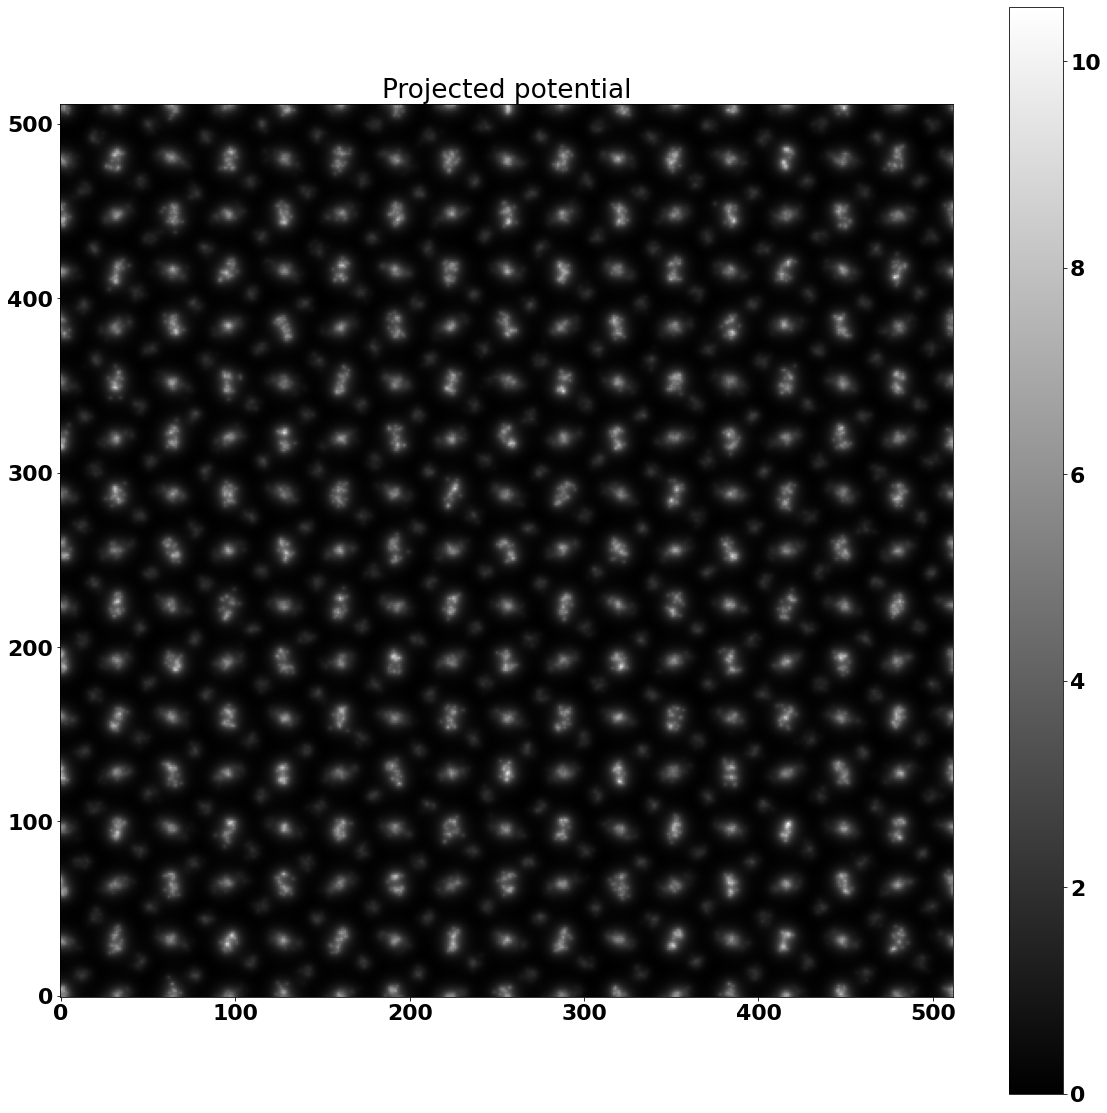

In [38]:
#%matplotlib inline
proj_pot = potential.project().array.astype(np.complex64) # in projected potential in eV*angstrom
interaction_parameter = energy2sigma(energy)
phase_shift=proj_pot*interaction_parameter 
plt.imshow(np.real(phase_shift).T, origin='lower', cmap='gray')
plt.colorbar()

plt.title("Projected potential")

In [37]:
probe.show()
plt.title("Probe")

Text(0.5, 1.0, 'Probe')

In [16]:
probe.angular_sampling

(0.43609418678539313, 0.4202751240746946)

In [17]:
dx=(potential.extent[0]/potential.gpts[0])
max_a=probe.wavelength/dx
max_a

0.22328021673336798

In [18]:
probe.wavelength/probe.sampling

array([0.22328022, 0.21518086])

In [19]:
probe.cutoff_scattering_angles

(71.51944663280447, 71.65690865473542)

In [20]:
probe.wavelength/probe.sampling/2*2/3

array([0.07442674, 0.07172695])

## Reconstruction

appling noise to simulated diffraction data

In [21]:
%%time
from abtem.utils import fft_interpolate_2d
from abtem.noise import poisson_noise
#band_limited_measurment = fft_interpolate_2d(measurement,[256,256]) # toto je strasne pomale a nenazrane!

measurement_intensity = measurement.intensity()

dose=1e6
measurement_noisy = poisson_noise(measurement_intensity, dose)/dose

#band_limited_measurment = bandlimit(measurement_noisy, 80)

#band_limited_measurment[0,0].show(power=1)

CPU times: user 11.5 s, sys: 5.43 s, total: 16.9 s
Wall time: 16.9 s


In [22]:
probe.angular_sampling[0]*probe.gpts[0]

223.28022363412128

Down sampling measured diffraction pattern by factor of `p_num`

In [23]:
p_num=2
shape_orig=np.shape(measurement_noisy)
array=np.zeros([shape_orig[0],shape_orig[1],shape_orig[2]//p_num,shape_orig[3]//p_num])

for i in range(np.shape(measurement_noisy)[0]):
    for j in range(np.shape(measurement_noisy)[1]):
        m = measurement_noisy.array[i,j]
        if p_num==1:
            array[i,j]=m
        else:
            array[i,j]=m[0::p_num,0::p_num]+m[0::p_num,1::p_num]+m[1::p_num,0::p_num]+m[1::p_num,1::p_num]

In [24]:
np.shape(array)
#print(m[1::2])

(35, 36, 256, 256)

In [25]:
#plt.imshow(array[0,0]**(0.25))
#plt.title("Diffraction pattern")

# Manipulating diffraction pattern data according

If `flag` is set to 
* `"downup"` then the noisy diffraction pattern will be downsampled and upsampled
* `"down"` the noisy diffraction pattern will be only downsampled 
* `skip_intensity` will skip downsampling and upsampling and the diffraction pattern will be without noise
* `skip_noisy` will skip downsampling and upsampling but the noise will be present in dffraction pattern

In [26]:
from abtem.measure import Measurement
from abtem.utils import fft_interpolate_2d

flag="downup"

if flag=="down": 

    cals=tuple(i.copy() for i in measurement_intensity.calibrations) # cannot use equals because it wouldnt copy but it would instead pass refference
    print("sampling in reciprocal space before:")
    print(cals[2].sampling,cals[3].sampling)
    cals[2].sampling*=p_num
    cals[3].sampling*=p_num
    print("sampling in reciprocal space after:")
    print(cals[2].sampling,cals[3].sampling)
    measurement_resampled= Measurement(array, calibrations=cals, name=measurement.name, units=measurement.units) 
elif flag=="downup":
    upsample_val=2
    array_upsampled=np.zeros([array.shape[0],array.shape[1],512,512])
    cals=tuple(i.copy() for i in measurement_intensity.calibrations) # cannot use equals because it wouldnt copy but it would instead pass refference
    print("sampling in reciprocal space before:")
    print(cals[2].sampling,cals[3].sampling)
    cals[2].sampling*=(p_num/upsample_val)
    cals[3].sampling*=(p_num/upsample_val)
    print("sampling in reciprocal space after:")
    print(cals[2].sampling,cals[3].sampling)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            array_upsampled[i,j]=np.abs(fft_interpolate_2d(array[i,j],new_shape=(512,512))) # Reconstruction looks better when fft interpolation is used rather then when from each pixel four are made
            #array_upsampled[i,j,0::upsample_val,0::upsample_val]=array[i,j]
            #array_upsampled[i,j,1::upsample_val,0::upsample_val]=array[i,j]
            #array_upsampled[i,j,0::upsample_val,1::upsample_val]=array[i,j]
            #array_upsampled[i,j,1::upsample_val,1::upsample_val]=array[i,j]
    measurement_resampled = Measurement(array_upsampled, calibrations=cals, name=measurement.name, units=measurement.units) 
elif flag=="skip_intensity":
    measurement_resampled= measurement_intensity
elif flag=="skip_noisy":
    measurement_resampled= measurement_noisy
else:
    raise Exception("wrong flag")

sampling in reciprocal space before:
0.4360941867853931 0.4202751240746946
sampling in reciprocal space after:
0.4360941867853931 0.4202751240746946


In [27]:
np.shape(measurement_resampled)

(35, 36, 512, 512)

In [28]:
#measurement_pokus = Measurement(measurement_resampled.array[0:30,0:30,:,:], calibrations=measurement.calibrations, name=measurement.name, units=measurement.units) 

Text(0.5, 1.0, 'Diffraction pattern')

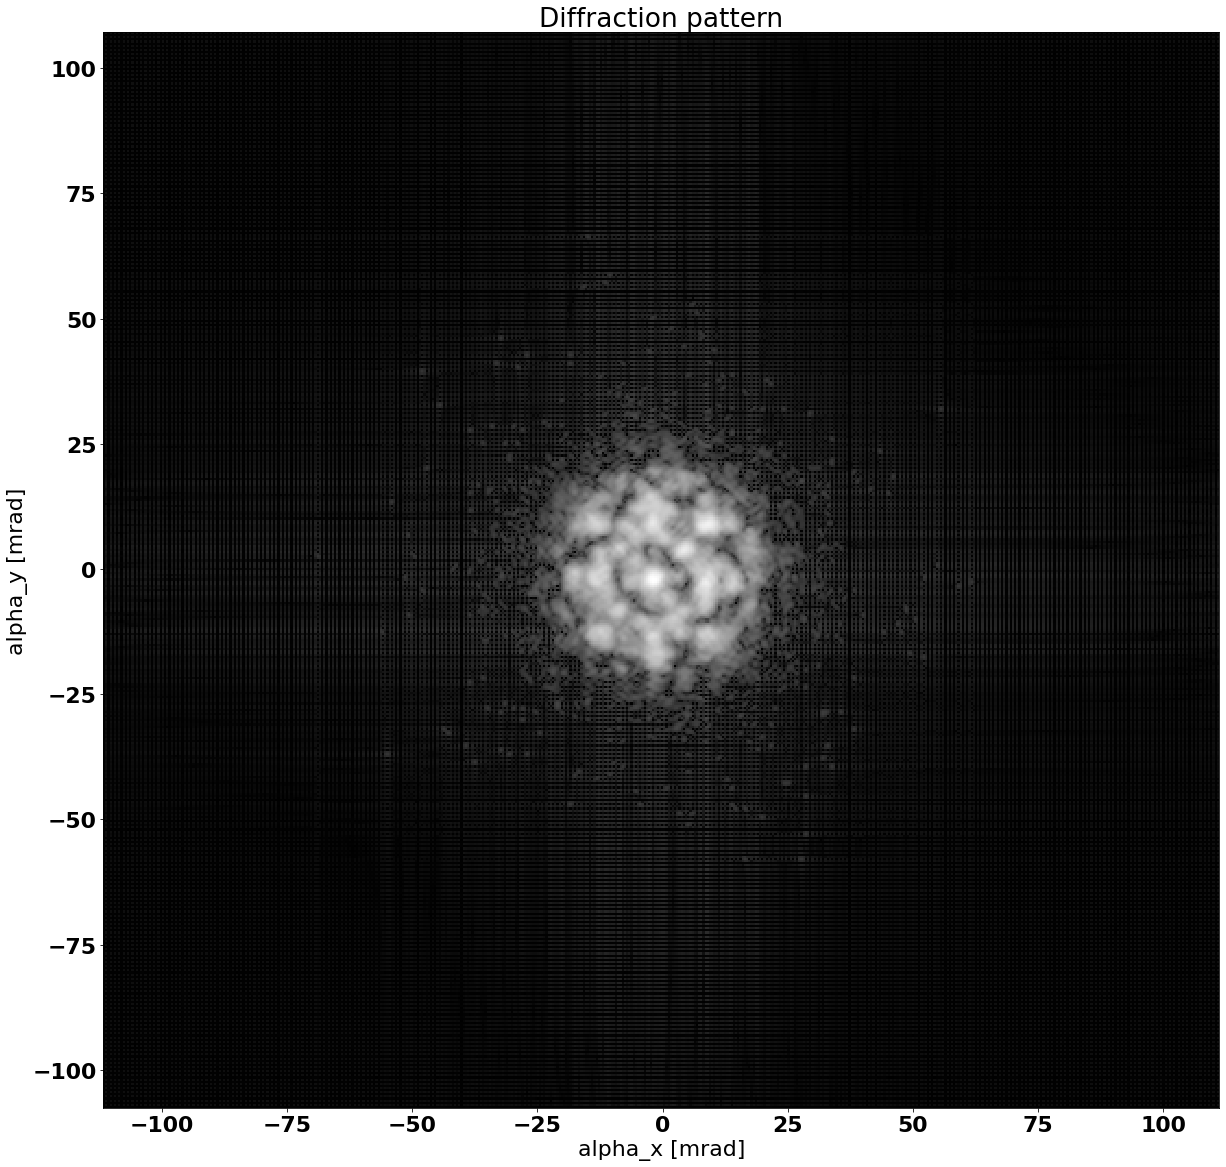

In [39]:
measurement_resampled[0,0].show(power=0.25)
plt.title("Diffraction pattern")

Making probe guess, with given aperture semiangle and beam energy. 

In [30]:
probe_guess = Probe(semiangle_cutoff=21.4, energy=energy,defocus=0*defocus/2,extent=40,gpts=256)

Text(0.5, 1.0, 'Initial probe')

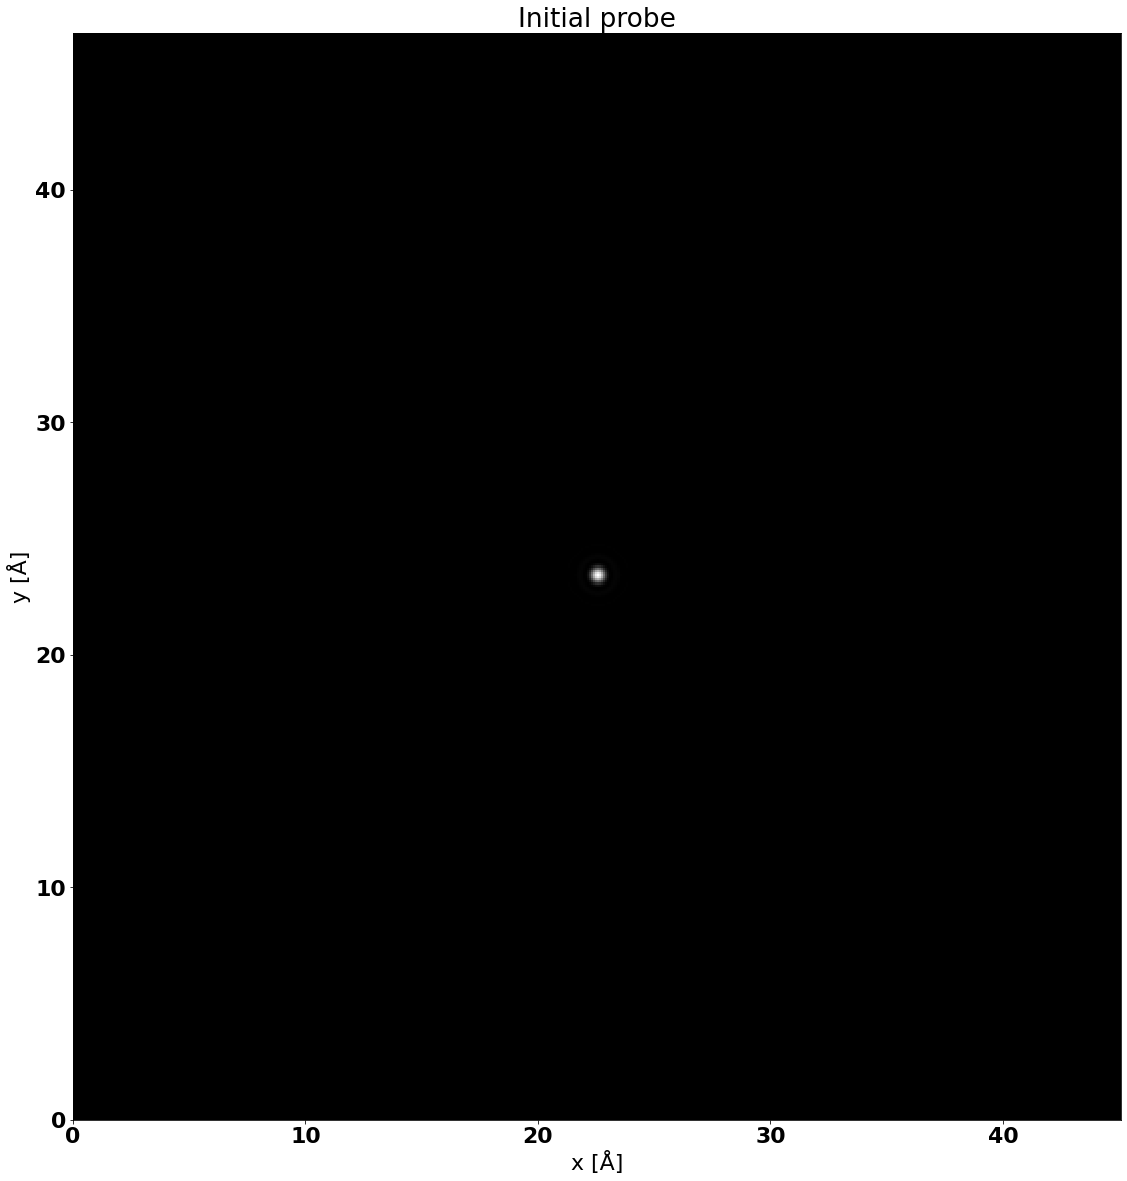

In [40]:
probe_guess.show()
plt.title("Initial probe")

In [32]:
print(probe_guess.sampling)

(0.15625, 0.15625)


In [33]:
%%time
reconstructions_full = epie(measurement_resampled, probe_guess, alpha=0.2, fac=0.2, beta=0.2, maxiter=8, return_iterations=True, fix_com=True,device='gpu')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1260 [00:00<?, ?it/s]

CPU times: user 30.3 s, sys: 6.45 s, total: 36.8 s
Wall time: 36.6 s


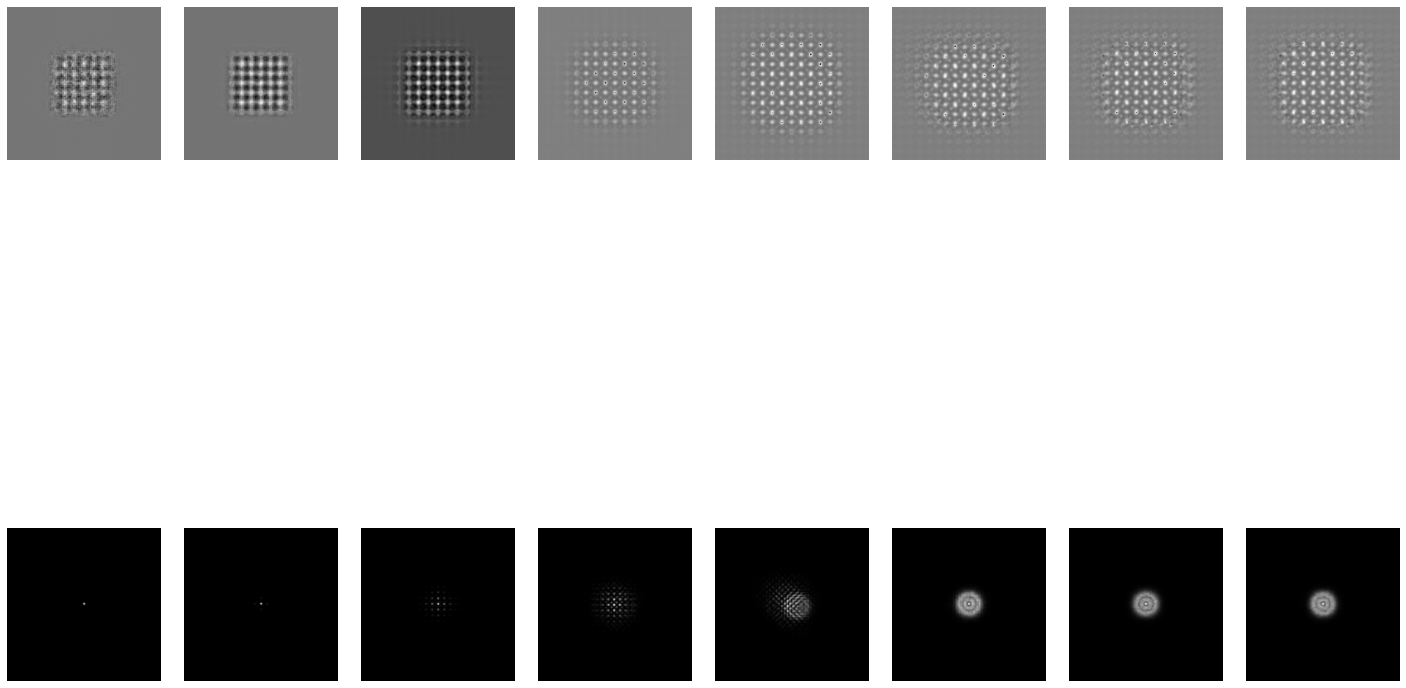

In [34]:
plot_every = 1

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_full[0]) / plot_every)), figsize=(20,20))

for i, j in enumerate(range(0, len(reconstructions_full[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_full[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_full[1][j].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

Text(0.5, 1.0, 'Reconstructed phase of the object')

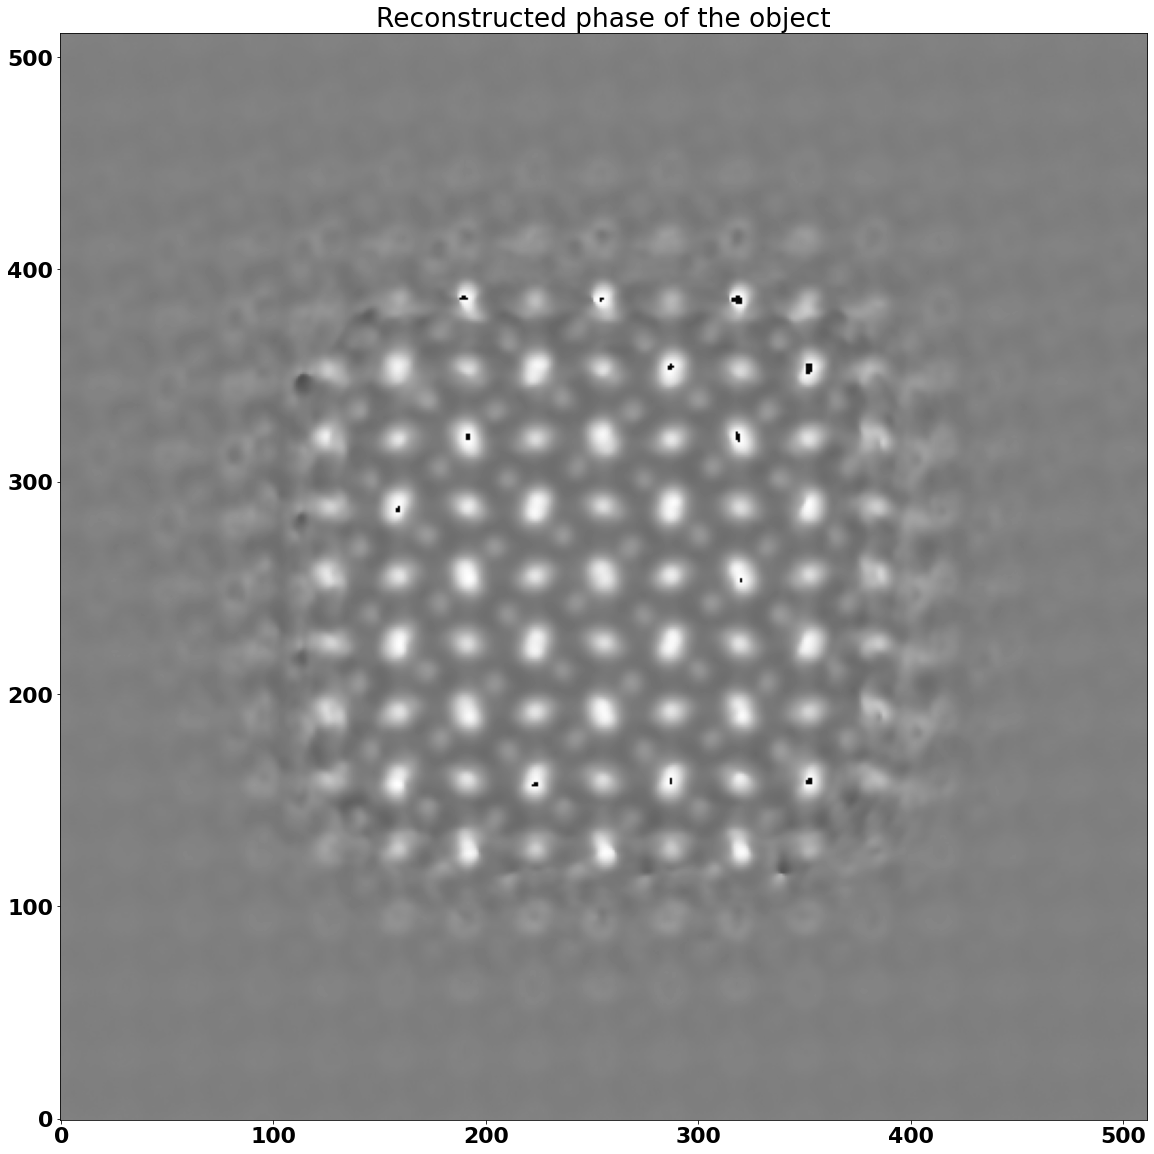

In [41]:
plt.imshow(np.angle(reconstructions_full[0][-1].array).T, origin='lower', cmap='gray')
#plt.savefig("04_figs/0.8nm_chromatic_0.5initial_defocus.pdf")
#plt.savefig("04_figs/0.8nm_poisson_chromatic_0.5initial_defocus.pdf")
plt.title("Reconstructed phase of the object")

In [42]:
plt.imshow(np.abs(reconstructions_full[1][-1].array).T ** 2, origin='lower', cmap='gray')
#plt.savefig("04_figs/0.8nm_chromatic_0.5initial_defocus_probe.pdf")
#plt.savefig("04_figs/0.8nm_poisson_chromatic_0.5initial_defocus_probe.pdf")
plt.title("Reconstructed intensity of the probe")

Text(0.5, 1.0, 'Reconstructed intensity of the probe')